In [5]:
import tweedledum as td
import logging
td.bool_function_compiler.setup_logging(logging.WARN)

from clique_counter import parameterized_clique_counter_cardinality
from qiskit_ibm_runtime import QiskitRuntimeService
from dotenv import load_dotenv, find_dotenv
import os

In [6]:
load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")

for backend in service.backends():
    config = backend.configuration()
    if "simulator" in config.backend_name:
        continue
    print(f"Backend: {config.backend_name}")
    print(f"    Processor type: {config.processor_type}")
    print(f"    Supported instructions:")
    for instruction in config.supported_instructions:
        print(f"        {instruction}")
    print()

Backend: ibm_rensselaer
    Processor type: {'family': 'Eagle', 'revision': 3}
    Supported instructions:
        ecr
        id
        delay
        measure
        reset
        rz
        sx
        x
        if_else
        for_loop
        switch_case



p cnf+ 4 4
-2 -3 0
-2 -4 0
-3 -4 0
1 2 3 4 >= 2
G has 3 cliques of size at least 2
Optimal iterations for N=4, M=3: 1


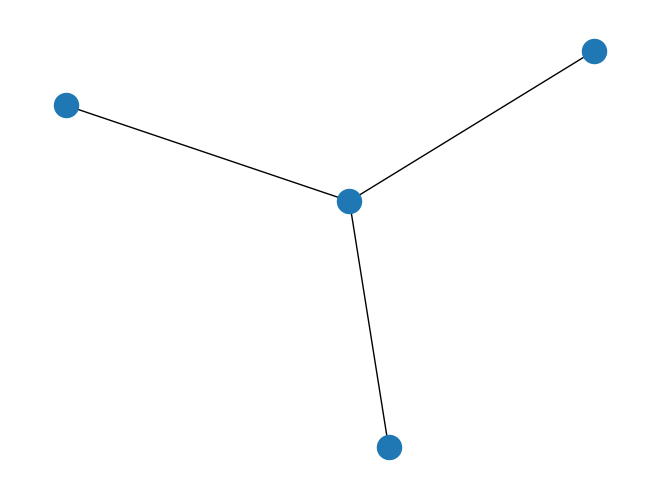

In [ ]:
# Generate Random graphwith
import networkx as nx
import numpy as np
import math
from clique_counter import direct_clique_to_cnf

def graph_to_binary_edge_list(g): 
    n = g.number_of_nodes()
    return [int(G.has_edge(i, j)) for i in range(0, n) for j in range(0, n)]

def count_cliques(graph, k):
    from networkx.algorithms import enumerate_all_cliques
    """Classically counts cliques of size <= k."""
    cliques = list(enumerate_all_cliques(graph))
    count = len([node_list for node_list in cliques if len(node_list) >= k])
    return count

def example():
    N=10
    k = 5
    G = nx.Graph()
    G.add_nodes_from([i for i in range(0, N)])
    G.add_edges_from([(0, 1), (0, 2), (0, 3)])
    return N, k, G


N, k, G= example()

edges = nx.to_numpy_array(G).flatten().tolist()
print(direct_clique_to_cnf(N, 2, edges))

m = count_cliques(G, k)
print(f"G has {m} cliques of size at least {k}")
nx.draw(G)

if m < (1 << N): # Avoid error if m=2^n
    optimal_iterations = math.floor(
        math.pi / (4 * math.asin(math.sqrt(m / (1 << N))))
    )

print(f"Optimal iterations for N={N}, M={m}: {optimal_iterations}")

def parameterized_clique_counter_cardinality(vertices: BitVec(4, '0000')) -> BitVec(1):
    """Counts cliques of size 2 in a graph specified by the edge list."""
    s = BitVec(1, 1)
    s = s & ~(vertices[1] & vertices[2])
    s = s & ~(vertices[1] & vertices[3])
    s = s & ~(vertices[2] & vertices[3])
    s_0_0 = BitVec(1, 1)
    s_0_1 = BitVec(1, 0)
    s_0_2 = BitVec(1, 0)
    s_1_0 = BitVec(1, 1)
    s_1_1 = s_0_1 | vertices[0] & s_0_0
    s_1_2 = BitVec(1, 0)
    s_2_0 = BitVec(1, 1)
    s_2_1 = s_1_1 | vertices[1] & s_1_0
    s_2_2 = s_1_2 | vertices[1] & s_1_1
    s_3_0 = BitVec(1, 1)
    s_3_1 = s_2_1 | vertices[2] & s_2_0
    s_3_2 = s_2_2 | vertices[2] & s_2_1
    s_4_0 = BitVec(1, 1)
    s_4_1 = s_3_1 | vertices[3] & s_3_0
    s_4_2 = s_3_2 | vertices[3] & s_3_1
    at_least_k = s_4_2
    return s & at_least_k


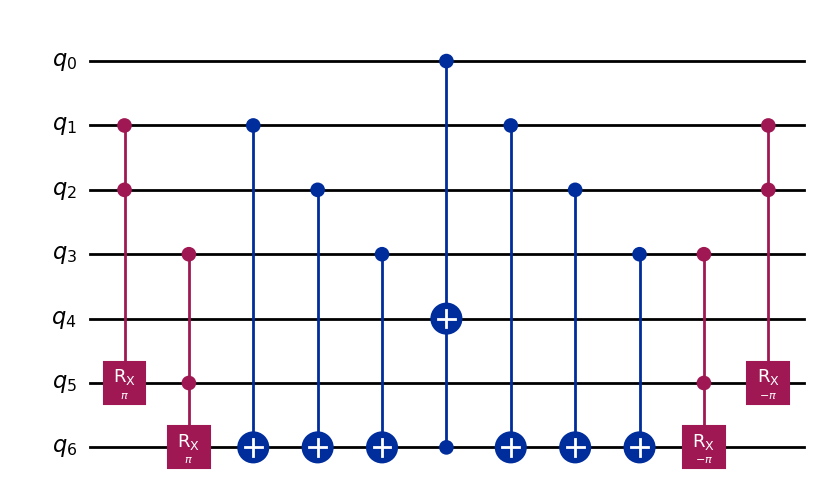

In [77]:
##### from graphviz import Source
from IPython.display import display # Import the display function
from tweedledum.bool_function_compiler import QuantumCircuitFunction

num_nodes = G.number_of_nodes()
edges = nx.to_numpy_array(G).flatten().tolist()

qc_function = QuantumCircuitFunction(parameterized_clique_counter_cardinality, num_nodes, k, edges)
print(qc_function.get_transformed_source())
# XAG Synthesis
oracle = qc_function.synthesize_quantum_circuit(output_xag_dot=True)

# Truth Table Synthesis
#oracle = qc_function.truth_table_synthesis()

display(oracle.draw("mpl"))

In [78]:
import qiskit
from qiskit.quantum_info import Statevector
import numpy as np
import math
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import grover_operator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Assume analyze_counts function is defined as before
# from __main__ import analyze_counts

def find_solution_grover(oracle, num_vertex_qubits, m=1, use_simulator=False):
    """
    Grover's algorithm using a pre-constructed PHASE-FLIP oracle

    Args:
        oracle: The Qiskit QuantumCircuit implementing the phase-flip oracle.
        num_vertex_qubits: The number of qubits in the search space (N).
        m: The estimated number of solutions (default: 1).
        use_simulator: Flag to use AerSimulator.

    Returns:
        A dictionary of measurement counts.
    """
    n = num_vertex_qubits
    if n < 1:
        print("Warning: Number of search qubits must be at least 1.")
        return {}
    total_qubits = oracle.num_qubits
    print(f"\nRunning Grover with MANUAL Diffusion (N={n}, Total Qubits={total_qubits})")

    # Ensure oracle has enough qubits for the search space
    if total_qubits < n:
         raise ValueError(f"Oracle qubit count ({total_qubits}) is less than search space ({n}).")

    # ---  Calculate Iterations ---
    if not (m >= 1 and m <= 2**n):
         print(f"Warning: Number of solutions m={m} is outside valid range [1, 2^N]. Assuming m=1.")
         m = 1

    optimal_iterations = 0
    if m < (1 << n): # Avoid error if m=2^n
        optimal_iterations = math.floor(
            math.pi / (4 * math.asin(math.sqrt(m / (1 << n))))
        )
    print(f"Optimal iterations for N={n}, M={m}: {optimal_iterations}")

    if optimal_iterations == 0 and m > 0:
        print("Warning: Optimal iterations calculated as 0. Grover search may not be effective.")
        # Still run once if you want to see oracle effect
        # optimal_iterations = 1

        
    search_circuit = qiskit.QuantumCircuit(total_qubits, n) # Classical bits for measuring N search qubits
    search_circuit.x(n)
    search_circuit.h(n)
    search_circuit.h(range(n))
    grover_op = grover_operator(oracle, reflection_qubits=range(n))
    search_circuit.compose(grover_op.power(optimal_iterations), inplace=True)
    #search_circuit.compose(grover_op.power(1), inplace=True)
    search_circuit.measure(range(n), range(n))
    print(grover_op.draw())

    # ---  Run Simulation ---
    
    simulator = AerSimulator()
    # Transpilation is likely needed because mcx might decompose further
    pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend)
    print("Transpiling final Grover circuit...")
    qc = pass_manager.run(search_circuit)
    print("Running simulation...")
    result = simulator.run(qc, shots=10**4).result()
    counts = result.get_counts()

    print("Submitting job")
    sampler = Sampler(backend)
    sampler.options.dynamical_decoupling.enable = True
    job = sampler.run([qc], shots=10**4)
    print(job.job_id())

    return job, counts

job, sim_counts = find_solution_grover(
    oracle=oracle,
    num_vertex_qubits=G.number_of_nodes(),
    m=m,
)


Running Grover with MANUAL Diffusion (N=4, Total Qubits=7)
Optimal iterations for N=4, M=3: 1
global phase: π
                                           ┌───┐┌───┐                         »
q_0: ───────────────────────────────────■──┤ H ├┤ X ├─────────────────────────»
                                        │  └───┘└───┘                         »
q_1: ────■───────────────■──────────────┼────■──────────────────────────■─────»
         │               │              │    │                          │     »
q_2: ────■───────────────┼────■─────────┼────┼────■─────────────────────■─────»
         │               │    │         │    │    │                     │     »
q_3: ────┼────────■──────┼────┼────■────┼────┼────┼────■──────■─────────┼─────»
         │        │      │    │    │  ┌─┴─┐  │    │    │      │         │     »
q_4: ────┼────────┼──────┼────┼────┼──┤ X ├──┼────┼────┼──────┼─────────┼─────»
     ┌───┴───┐    │      │    │    │  └─┬─┘  │    │    │      │     ┌───┴────┐»
q_5: ┤ Rx

{'0110': 577, '1100': 643, '1000': 615, '0001': 609, '0000': 601, '1011': 610, '0111': 652, '1101': 628, '0011': 644, '1010': 609, '0100': 634, '1111': 638, '0101': 592, '1001': 615, '0010': 629, '1110': 704}


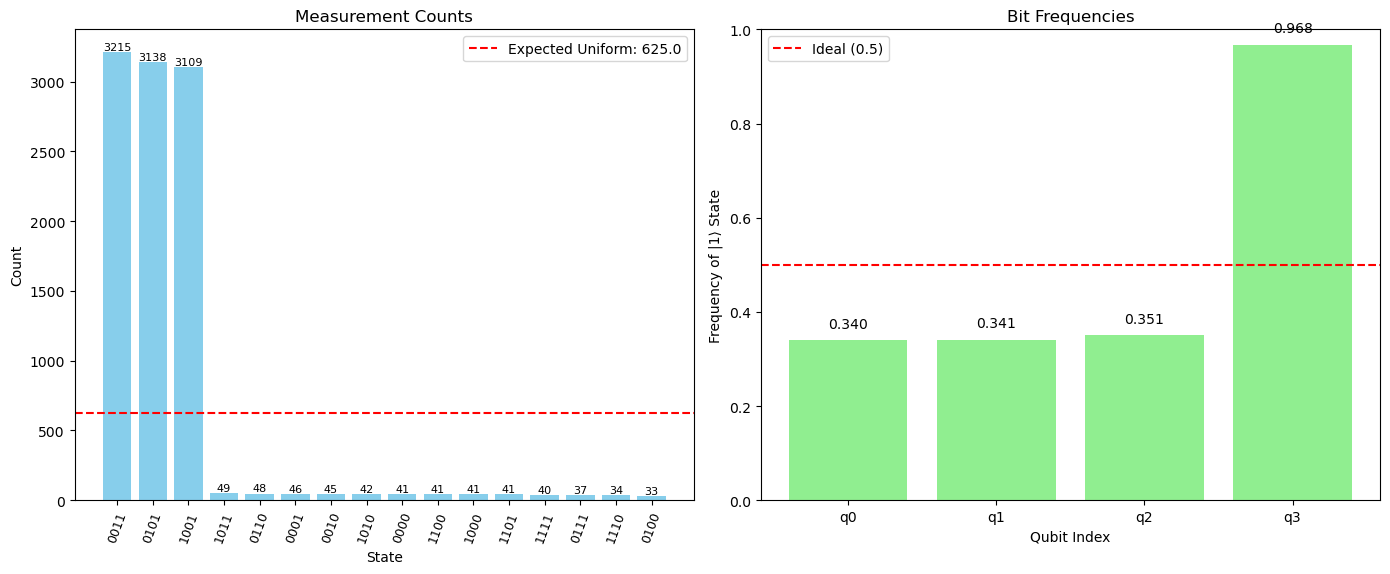

Total samples: 10000
Highest state: 0011 (3215 counts, 32.15%)
Lowest state: 0100 (33 counts, 0.33%)
✓ Strong signal detected in state 0011 (32.1%)


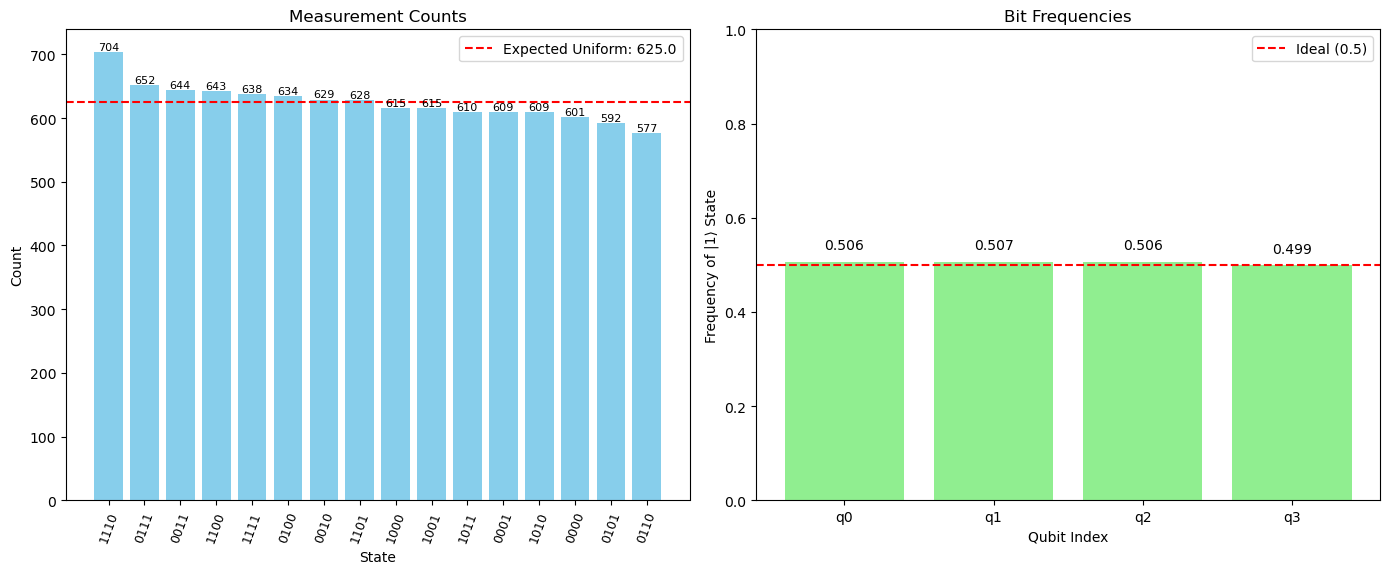

Total samples: 10000
Highest state: 1110 (704 counts, 7.04%)
Lowest state: 0110 (577 counts, 5.77%)
⚠ No clear winner detected. Top state has only 7.0% probability
⚠ Distribution appears close to uniform (max variation: 0.8%)


{'total_samples': 10000,
 'top_state': '1110',
 'top_probability': 0.0704,
 'bit_frequencies': {'q0': np.float64(0.5062),
  'q1': np.float64(0.5068),
  'q2': np.float64(0.5063),
  'q3': np.float64(0.4988)}}

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def simple_visualize_results(results_dict, title="Quantum Measurement Results"):
    """
    A simple visualization for quantum measurement results.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with quantum states as keys and counts as values
    title : str, optional
        Title for the visualization
    """
    # Basic calculations
    total_samples = sum(results_dict.values())
    n_qubits = len(list(results_dict.keys())[0])
    
    # Sort results by count (descending)
    sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Bar chart of states
    bars = ax1.bar(range(len(sorted_results)), sorted_results.values(), color='skyblue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Set the x-tick positions and labels
    ax1.set_xticks(range(len(sorted_results)))
    ax1.set_xticklabels(list(sorted_results.keys()), rotation=70, fontsize=9)
    
    # Add uniform expectation line
    expected_uniform = total_samples / len(results_dict)
    ax1.axhline(y=expected_uniform, color='red', linestyle='--', 
                label=f'Expected Uniform: {expected_uniform:.1f}')
    
    ax1.set_title('Measurement Counts')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    # 2. Bit frequencies
    bit_counts = np.zeros(n_qubits)
    
    for state, count in results_dict.items():
        for i, bit in enumerate(state):
            if bit == '1':
                bit_counts[i] += count
    
    bit_frequencies = bit_counts / total_samples
    
    bars = ax2.bar(range(n_qubits), bit_frequencies, color='lightgreen')
    ax2.axhline(0.5, color='red', linestyle='dashed', label='Ideal (0.5)')
    
    # Add frequency values on top of bars
    for bar, freq in zip(bars, bit_frequencies):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{freq:.3f}', ha='center', va='bottom')
    
    ax2.set_ylim(0, 1)
    ax2.set_title('Bit Frequencies')
    ax2.set_xlabel('Qubit Index')
    ax2.set_ylabel('Frequency of |1⟩ State')
    ax2.set_xticks(range(n_qubits))
    ax2.set_xticklabels([f'q{i}' for i in range(n_qubits)])
    ax2.legend()
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print simple statistics
    print(f"Total samples: {total_samples}")
    print(f"Highest state: {list(sorted_results.keys())[0]} ({list(sorted_results.values())[0]} counts, {list(sorted_results.values())[0]/total_samples*100:.2f}%)")
    print(f"Lowest state: {list(sorted_results.keys())[-1]} ({list(sorted_results.values())[-1]} counts, {list(sorted_results.values())[-1]/total_samples*100:.2f}%)")
    
    # Check for clear winner (probability > 20%)
    top_prob = list(sorted_results.values())[0] / total_samples
    if top_prob > 0.2:
        print(f"✓ Strong signal detected in state {list(sorted_results.keys())[0]} ({top_prob*100:.1f}%)")
    else:
        print(f"⚠ No clear winner detected. Top state has only {top_prob*100:.1f}% probability")
    
    # Check for uniformity
    uniformity_threshold = 0.05  # 5% variation
    max_variation = max(abs(count/total_samples - 1/len(results_dict)) for count in results_dict.values())
    
    if max_variation < uniformity_threshold:
        print(f"⚠ Distribution appears close to uniform (max variation: {max_variation*100:.1f}%)")
    
    # Return a simple summary for programmatic use
    return {
        "total_samples": total_samples,
        "top_state": list(sorted_results.keys())[0],
        "top_probability": top_prob,
        "bit_frequencies": {f"q{i}": freq for i, freq in enumerate(bit_frequencies)}
    }

hw_counts = job.result()[0].data.c.get_counts()
print(hw_counts)

simple_visualize_results(sim_counts, "")
simple_visualize_results(hw_counts, "")

In [81]:
from typing import Dict, Union, List

def calculate_quantum_advantage(
    N: int,
    m: int,
    hardware_counts: Dict[str, int],
    grover_iterations: int,
    valid_solutions: Union[List[str], None] = None,
) -> Dict[str, float]:
    """
    Calculate quantum advantage factor for a Grover's algorithm experiment.
    
    Args:
        N: Search space size (2^n where n is number of qubits)
        m: Number of valid solutions in the search space
        hardware_counts: Dictionary of measurement outcomes and their counts
                        e.g., {"000": 512, "001": 23, "010": 45, ...}
        grover_iterations: Number of Grover iterations performed (k)
        valid_solutions: List of bit strings that are valid solutions
                        If None, assumes you've already filtered hardware_counts
    
    Returns:
        Dictionary containing:
        - 'success_probability': Measured probability of finding a solution
        - 'quantum_advantage_factor': Factor > 1 means quantum advantage retained
        - 'classical_oracle_calls': Expected classical oracle calls (N/m)
        - 'quantum_oracle_calls': Expected quantum oracle calls (k/p)
        - 'speedup': How many times faster quantum is (if > 1)
    
    Example:
        >>> counts = {"000": 50, "001": 450, "010": 30, "111": 470}
        >>> solutions = ["001", "111"]  # These are the valid solutions
        >>> result = calculate_quantum_advantage(
        ...     N=8,           # 2^3 = 8 total items
        ...     m=2,           # 2 valid solutions
        ...     hardware_counts=counts,
        ...     grover_iterations=2,
        ...     valid_solutions=solutions
        ... )
        >>> print(f"Success probability: {result['success_probability']:.2%}")
        >>> print(f"Quantum advantage factor: {result['quantum_advantage_factor']:.2f}")
    """
    
    # Calculate total shots
    total_shots = sum(hardware_counts.values())
    if total_shots == 0:
        raise ValueError("No measurement data provided")
    
    # Calculate success probability
    if valid_solutions is not None:
        # Count successful measurements
        successful_shots = sum(
            count for bitstring, count in hardware_counts.items()
            if bitstring in valid_solutions
        )
    else:
        # Assume all provided counts are already filtered for success
        successful_shots = total_shots
    
    success_probability = successful_shots / total_shots
    
    # Avoid division by zero
    if success_probability == 0:
        return {
            'success_probability': 0.0,
            'quantum_advantage_factor': 0.0,
            'classical_oracle_calls': N / m,
            'quantum_oracle_calls': float('inf'),
            'speedup': 0.0,
        }
    
    # Calculate oracle calls
    classical_oracle_calls = N / m
    quantum_oracle_calls = grover_iterations / success_probability
    
    # Calculate quantum advantage factor
    quantum_advantage_factor = (success_probability * N) / (m * grover_iterations)
    
    return {
        'success_probability': success_probability,
        'quantum_advantage_factor': quantum_advantage_factor,
        'classical_oracle_calls': classical_oracle_calls,
        'quantum_oracle_calls': quantum_oracle_calls,
        'speedup': classical_oracle_calls / quantum_oracle_calls,
    }

print(calculate_quantum_advantage(2**N, m, sim_counts, optimal_iterations, ["0011", "0101", "1001"]))

calculate_quantum_advantage(2**N, m, hw_counts, optimal_iterations, ["0011", "0101", "1001"])
#calculate_quantum_advantage(2**N, m, sim_counts, 1, ["011"])

{'success_probability': 0.9462, 'quantum_advantage_factor': 5.0464, 'classical_oracle_calls': 5.333333333333333, 'quantum_oracle_calls': 1.056859015007398, 'speedup': 5.0464}


{'success_probability': 0.1851,
 'quantum_advantage_factor': 0.9872,
 'classical_oracle_calls': 5.333333333333333,
 'quantum_oracle_calls': 5.4024851431658565,
 'speedup': 0.9871999999999999}